In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv("jena_climate_2009_2016.csv")

In [21]:
temperature = df["T (degC)"].values

In [22]:
raw_data = df.loc[:, "p (mbar)":"wd (deg)"].values

**Data split**

In [23]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

**Normalizing the data**

In [25]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**Instantiating datasets for training, validation, and testing**

In [26]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [27]:
train_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Training and evaluating a dropout-regularized LSTM**

In [11]:
inputs = Input(shape=(sequence_length, raw_data.shape[-1]))
x = LSTM(32, recurrent_dropout=0.25)(inputs)
x = Dropout(0.5)(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

callbacks = [ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)]

In [13]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 325s 394ms/step - loss: 13.8656 - mae: 2.8843 - val_loss: 9.2710 - val_mae: 2.3694
Epoch 2/5
819/819 [==============================] - 326s 398ms/step - loss: 13.0851 - mae: 2.8137 - val_loss: 9.3336 - val_mae: 2.3737
Epoch 3/5
819/819 [==============================] - 327s 399ms/step - loss: 12.5756 - mae: 2.7506 - val_loss: 9.1875 - val_mae: 2.3608
Epoch 4/5
819/819 [==============================] - 318s 388ms/step - loss: 12.1985 - mae: 2.7096 - val_loss: 9.4571 - val_mae: 2.4023
Epoch 5/5
819/819 [==============================] - 318s 388ms/step - loss: 11.8362 - mae: 2.6723 - val_loss: 9.4447 - val_mae: 2.3943


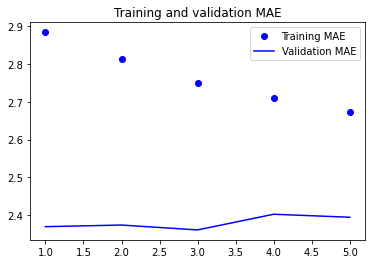

In [14]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

#### cuDNN Fix

In [38]:
num_features = 14
inputs = Input(shape=(sequence_length, num_features))
x = LSTM(32, return_sequences=True, recurrent_dropout=0.2, unroll=True)(inputs)
x = Dropout(0.5)(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

callbacks = [ModelCheckpoint("jena_lstm_unroll.keras", save_best_only=True)]

In [39]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history1 = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 161s 160ms/step - loss: 81.7909 - mae: 7.3143 - val_loss: 67.1546 - val_mae: 6.7402
Epoch 2/5
819/819 [==============================] - 124s 151ms/step - loss: 78.4855 - mae: 7.1727 - val_loss: 66.6673 - val_mae: 6.7181
Epoch 3/5
819/819 [==============================] - 123s 150ms/step - loss: 78.1891 - mae: 7.1599 - val_loss: 66.2180 - val_mae: 6.6972
Epoch 4/5
819/819 [==============================] - 120s 146ms/step - loss: 77.9885 - mae: 7.1514 - val_loss: 66.0767 - val_mae: 6.6906
Epoch 5/5
819/819 [==============================] - 121s 148ms/step - loss: 77.8309 - mae: 7.1443 - val_loss: 66.6316 - val_mae: 6.7170


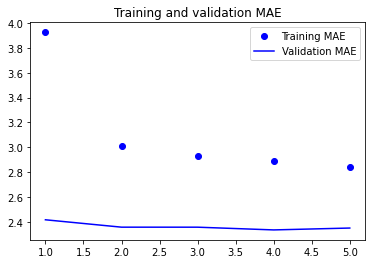

In [34]:
loss = history1.history["mae"]
val_loss = history1.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()